In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
from rdkit.Chem import rdmolops
import psycopg2
import json

hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

In [12]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'scotland'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True

In [3]:
def create_single_conf(smi,confid,MMFF_minimization = False,save = False,store=False,return_mol=False):
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    if MMFF_minimization:
        Chem.SanitizeMol(mol)
        AllChem.MMFFOptimizeMolecule(mol)
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("_Name", used_smiles)
    mol.UpdatePropertyCache(strict=False)
    if save:
        print(Chem.MolToMolBlock(mol),file=open(f'mols_3d/{confid}.mol','w+'))
    if store:
        lwreg.register(config=config, mol=mol)   
    if return_mol:
        return mol      

In [4]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = """
SELECT mdfp_experiment_data.confid, 
       mdfp_experiment_data.mdfp, 
       conformers.molregno, 
       experimental_data.*
FROM cs_mdfps_schema.mdfp_experiment_data
INNER JOIN public.conformers ON mdfp_experiment_data.confid = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.experimental_data ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
"""

# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(len(results))
print(results[0])
confids = [x[0] for x in results]
smiles = [x[7]['SMILES'] for x in results]
print(len(smiles))
smiles[0]

3019
(1150, {'mdfp': '[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.361432252633201, 0.2837151924402524, 7.34042141946558, 14.033742219875462, 5.018821051018752, 13.296541873715412, 3.0175857863467783, 4.353506155897645, 3.780431651235485, -52.02286927297752, 7.64448526452626, -52.45103811827988, 21.39517447250866, 4.952106406604119, 20.619064966261192, -49.00528348663075, 8.735995589648539, -49.230908851076755, 0.2920177211844079, 0.017855504243481337, 0.2924185563222354, 3.8179197, 0.071479075, 3.8226213]'}, 7, 7, 0, {}, -0.3010669122639207, {'SMILES': '[CH3]-[CH]=[CH]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH3]', 'Source': 298.15, 'Temperature': 298.15})
3019


'[CH3]-[CH]=[CH]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH3]'

In [5]:
for smi,confid in zip(smiles,confids):
    create_single_conf(smi,confid)

KeyboardInterrupt: 

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

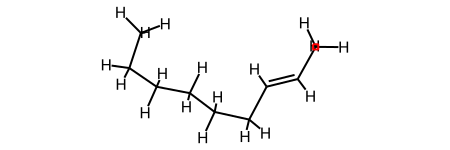

In [6]:
from rdkit.Chem.rdDistGeom import EmbedMultipleConfs,EmbedMolecule
test_mol = Chem.AddHs(Chem.MolFromSmiles(smiles[0], sanitize=False))
EmbedMolecule(test_mol, enforceChirality=True, randomSeed=0xf00d)
test_mol

In [7]:
test_mol_multiple_confs = Chem.Mol(test_mol)
EmbedMultipleConfs(test_mol_multiple_confs,randomSeed=0xf00d,enforceChirality=True,numConfs=10,pruneRmsThresh=0.5,clearConfs=False)
test_mol_multiple_confs
#get rmsd between first conf of test_mol_multiple_confs and test_mol
from rdkit.Chem import rdMolAlign
print(rdMolAlign.AlignMol(test_mol,test_mol_multiple_confs,0,0))
#and for a different conf
print(rdMolAlign.AlignMol(test_mol,test_mol_multiple_confs,0,1))
#splendid. So we just do it like this.

0.0
2.0444396989036604


1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

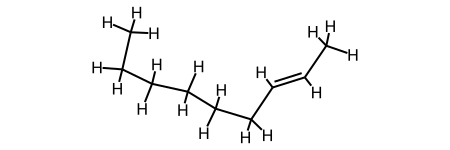

In [8]:
def create_diverse_confs(smi,confid,save = False,store=False):
    mol_3d = create_single_conf(smi,confid,MMFF_minimization = True,save = False,store=False,return_mol=True)
    EmbedMultipleConfs(mol_3d,randomSeed=0xf00d,enforceChirality=True,numConfs=1000,pruneRmsThresh=0.5,clearConfs=False,useRandomCoords=False)
    if store:
        for i in range(mol_3d.GetNumConformers()):
            cp = Chem.Mol(mol_3d,confId=i)
            print(cp.GetNumConformers(), cp.GetConformer().GetId())
    return mol_3d
mol_3d = create_diverse_confs(smiles[0],confids[0],store=True)
mol_3d

    

In [ ]:
#okay, this is not so straightforward, seems like we need to to some exploring first.
#lets start with taking a subset of ~100 molecules with different amounts of rotatable bonds. 


(array([1517.,  906.,  353.,  127.,   69.,   23.,    9.,    6.,    5.,
           4.]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <BarContainer object of 10 artists>)

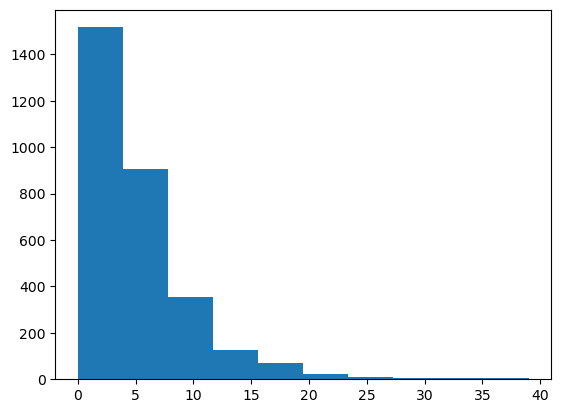

In [11]:
mols2d = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in smiles]
#get number of rotatable bonds for each
num_rot_bond = [Chem.rdMolDescriptors.CalcNumRotatableBonds(mol) for mol in mols2d]
#plot in histogram
import matplotlib.pyplot as plt
plt.hist(num_rot_bond)


[337 439 440 301 321 241 204 140 121 106  75  51  53  24  33  17  16  20
  18  15   6   6   7   4   3   2   2   2   2   1   1   2   1   2   1   1
   0   3   1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[33, 41, 46, 52, 69, 1, 6, 9, 10, 14, 3, 16, 26, 43, 45, 2, 7, 8, 39, 68, 5, 13, 17, 29, 30, 65, 81, 101, 119, 125, 12, 38, 48, 85, 88, 0, 19, 27, 64, 94, 4, 11, 23, 56, 75, 22, 28, 162, 193, 196, 15, 40, 70, 90, 205, 21, 24, 113, 146, 160, 18, 77, 121, 159, 265, 91, 261, 302, 360, 389, 25, 35, 97, 123, 133, 254, 310, 358, 405, 507, 32, 229, 1187, 1214, 1348, 257, 290, 391, 393, 623, 156, 192, 221, 253, 618, 151, 174, 215, 242, 439, 263, 417, 762, 787, 2537, 483, 1250, 1721, 2452, 2876, 340, 531, 816, 1170, 1529, 145, 252, 1738, 3005, 191, 1027, 1286, 449, 2709, 1981, 2890, 828, 2343, 1464, 2129, 1534, 2429, 1664, 2221, 1629, 312, 337, 1564, 3009, 1799, 2016, 3010]
142


(array([20., 20., 20., 15., 20., 20.,  9.,  7.,  6.,  5.]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

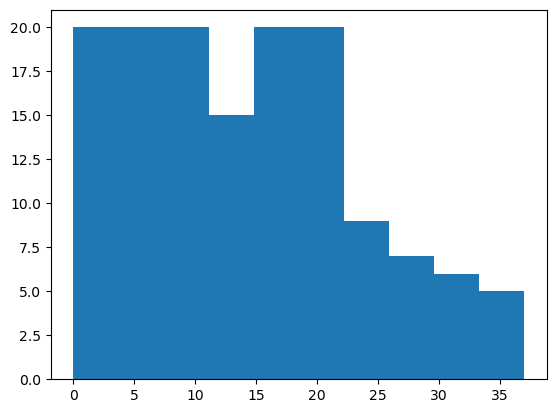

In [18]:
#lets pick a representable subset from this, making bins of 1, and sampling according to the number of molecules in each bin.
import numpy as np
bins = np.arange(0,40,1)
hist, bin_edges = np.histogram(num_rot_bond,bins)
print(hist)
print(bin_edges)
#lets just take the first 10 molecules from each bin
indices = []
for i in range(len(hist)):
    indices.extend(np.where(np.array(num_rot_bond)==i)[0][:5])
print(indices)
print(len(indices))
#do a histogram of the number of rotatable bonds for this subset
plt.hist(np.array(num_rot_bond)[indices])

In [20]:
#great! lets save the subset to a list
subset_mols = [mols2d[i] for i in indices]
#for each of these, generate 100 conformers
for i,mol in enumerate(subset_mols):
    print(i)
    EmbedMultipleConfs(mol,randomSeed=0xf00d,enforceChirality=True,numConfs=100,useRandomCoords=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141


In [57]:
def get_rms_to_first(mol):
    errors= AllChem.GetConformerRMSMatrix(mol)
    num_rows = int((-1 + (1 + 8 * len(errors))**0.5) / 2)
    first_column_indices = []
    for row in range(num_rows):
        first_column_indices.append(row * (row + 1) // 2)
    return [errors[i] for i in first_column_indices]

100%|██████████| 142/142 [00:30<00:00,  4.62it/s]


(array([46., 10., 13., 19., 15., 12., 10., 13.,  4.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <BarContainer object of 9 artists>)

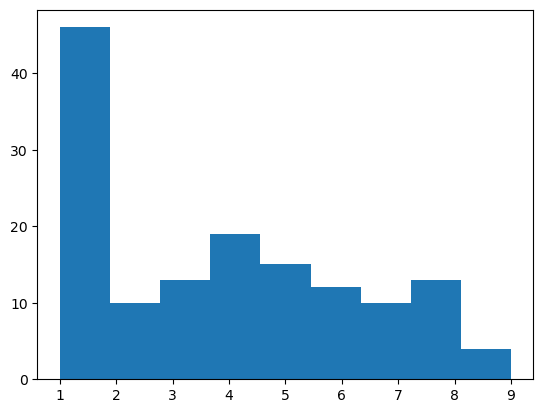

In [79]:
from rdkit.ML.Cluster import Butina
from tqdm import tqdm
clusts_lol,clust_counter_lol = [],[]
dist = 0.1
for mol in tqdm(subset_mols):
    dists = AllChem.GetConformerRMSMatrix(mol)
    clusts = Butina.ClusterData(dists, mol.GetNumConformers(), dist, isDistData=True, reordering=True)
    while len(clusts) >= 10:
        dist += 0.1
        clusts = Butina.ClusterData(dists, mol.GetNumConformers(), dist, isDistData=True, reordering=True)
    clusts_lol.append(clusts)
    clust_counter_lol.append(len(clusts))
plt.hist(clust_counter_lol,bins=9)


Slope: 0.10789966178128516, intercept: 2.2386245772266076, r_value: 0.39725272462786837, p_value: 9.833704755855716e-07, std_err: 0.021066592348398614


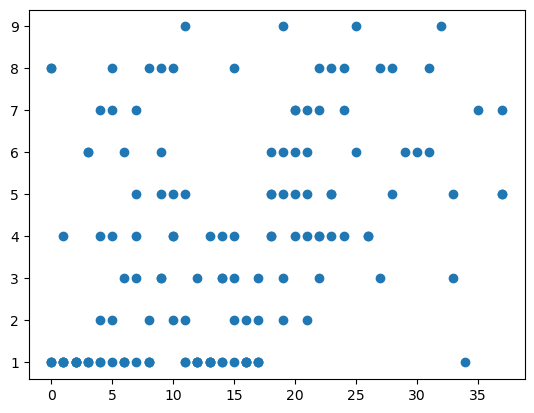

In [80]:
#do a scatter plot, plotting number of rotatable bonds on the x axis against number of clusters on the y axis
num_rot_bond_subset = [Chem.rdMolDescriptors.CalcNumRotatableBonds(mol) for mol in subset_mols]
plt.scatter(num_rot_bond_subset,clust_counter_lol)
#do linear fit and get statistics
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(num_rot_bond_subset,clust_counter_lol)
print(f'Slope: {slope}, intercept: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}')

In [67]:
def get_highest_rms_to_minimum(mol):
    errors= AllChem.GetConformerRMSMatrix(mol)
    num_rows = int((-1 + (1 + 8 * len(errors))**0.5) / 2)
    first_column_indices = []
    for row in range(num_rows):
        first_column_indices.append(row * (row + 1) // 2)
    errors_to_minimum =  [errors[i] for i in first_column_indices]
    indices = sorted(range(len(errors_to_minimum)), key = lambda sub: errors_to_minimum[sub])[-5:]
    #get the rmsd values corresponding to these indices
    max_errors = [errors_to_minimum[i] for i in indices]
    return indices,max_errors
    

In [68]:
get_highest_rms_to_minimum(subset_mols[0])

([16, 71, 47, 88, 45],
 [0.05167202355451939,
  0.053589762187481224,
  0.0554219122115284,
  0.05565038722274891,
  0.05780519561909495])

In [74]:
ms = mols2d
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
fps = [GetMorganFingerprint(x,3) for x in ms]
nfps = len(fps)
def distij(i,j,fps=fps):
    return 1-DataStructs.DiceSimilarity(fps[i],fps[j])

In [75]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,10,seed=23)
list(pickIndices)

[1561, 875, 2016, 2474, 33, 1637, 793, 1423, 2207, 185]

In [78]:
def test(i,j,fps=fps):
    return DataStructs.DiceSimilarity(fps[i],fps[j])
test

<function __main__.test(i, j, fps=[<rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350cac0>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350cc80>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350cdd0>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350ce40>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350ceb0>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350cf20>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350cf90>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350d000>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350d070>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350d0e0>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350d150>, <rdkit.DataStructs.cDataStructs.UIntSparseIntVect object at 0x7f91c350d1c0>, <rdkit.DataStructs.cDataStructs.UIntSpars

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True
mol = Chem.AddHs(Chem.MolFromSmiles('CCCCCCCCCCCC'))
rdDistGeom.EmbedMultipleConfs(mol, numConfs=100, randomSeed=0xf00d)

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.SimDivFilters import rdSimDivPickers

# Load your molecule and its conformers

conformers = [mol.GetConformer(i) for i in range(mol.GetNumConformers())]

# Calculate the pairwise RMSD matrix
rmsd_matrix = AllChem.GetConformerRMSMatrix(mol)

# Initialize the MaxMinPicker
picker = rdSimDivPickers.MaxMinPicker()

# Set the number of conformers you want to sample (X)
num_to_pick = 5

# Pick diverse conformers using MaxMinPicker
selected_indices = picker.LazyPick(rmsd_matrix, len(conformers), num_to_pick)

# Retrieve the selected conformers
selected_conformers = [conformers[i] for i in selected_indices]


TypeError: 'list' object is not callable

In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.SimDivFilters import rdSimDivPickers

# Load your molecule and its conformers

conformers = [mol.GetConformer(i) for i in range(mol.GetNumConformers())]

# Initialize the MaxMinPicker
picker = rdSimDivPickers.MaxMinPicker()

# Set the number of conformers you want to sample (X)
cluster_picker = rdSimDivPickers.HierarchicalClusterPicker(rdSimDivPickers.ClusterMethod.CLINK)

# Set the number of conformers you want to sample (X)
num_to_pick = 5
import numpy as np
rmsd_matrix = np.array(AllChem.GetConformerRMSMatrix(mol))

# Perform hierarchical clustering
clusters = cluster_picker.Cluster(rmsd_matrix, len(conformers), num_to_pick)

# Retrieve the selected conformers from the clusters
selected_indices = [cluster[0] for cluster in clusters]
selected_conformers = [conformers[i] for i in selected_indices]

In [25]:
#get the rmsd value pairs for the selected conformers
from rdkit.Chem.rdMolAlign import GetBestRMS
for i in selected_indices:
    for j in selected_indices:
        #get the rmsd value
        if i != j:
            rms = GetBestRMS(mol,mol,i,j)
            print(f'rmsd between confs {i} and {j}: {rms}')

rmsd between confs 0 and 1: 1.6406240940291983
rmsd between confs 0 and 2: 1.8722653193768415
rmsd between confs 0 and 5: 1.6433885278426976
rmsd between confs 0 and 7: 1.8256365422533187
rmsd between confs 1 and 0: 1.6406240940287844
rmsd between confs 1 and 2: 1.8024643381882195
rmsd between confs 1 and 5: 1.8243843646411149
rmsd between confs 1 and 7: 1.829160881469232
rmsd between confs 2 and 0: 1.8722653192011285
rmsd between confs 2 and 1: 1.8024643382159675
rmsd between confs 2 and 5: 1.796458931487025
rmsd between confs 2 and 7: 1.806824785064851
rmsd between confs 5 and 0: 1.6433885278426956
rmsd between confs 5 and 1: 1.8243843646411106
rmsd between confs 5 and 2: 1.7964589314830115
rmsd between confs 5 and 7: 1.762905704522039
rmsd between confs 7 and 0: 1.8256365422383298
rmsd between confs 7 and 1: 1.829160881467939
rmsd between confs 7 and 2: 1.8068247850648327
rmsd between confs 7 and 5: 1.7629057045206389


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   1.,   1.,   0.,
          1.,   5.,   7.,   2.,   8.,   5.,   6.,   5.,  12.,  13.,  19.,
         19.,  23.,  20.,  27.,  27.,  32.,  42.,  48.,  65.,  73.,  71.,
         96.,  96.,  90., 100., 131., 131., 141., 190., 168., 176., 186.,
        198., 181., 184., 168., 184., 172., 167., 136., 142., 117., 114.,
        127., 100.,  91.,  90.,  87.,  84.,  75.,  66.,  47.,  56.,  52.,
         44.,  39.,  22.,  22.,  20.,  21.,  17.,  11.,  11.,   6.,   9.,
          7.,   6.,   6.,   5.,   7.,   2.,   5.,   3.,   1.,   3.,   0.,
          2.]),
 array([1.01525831, 1.03553692, 1.05581553, 1.07609414, 1.09637274,
        1.11665135, 1.13692996, 1.15720857, 1.17748718, 1.19776579,
        1.21804439, 1.238323  , 1.25860161, 1.27888022, 1.29915883,
        1.31943744, 1.33971605, 1.35999465, 1.38027326, 1.40055187,
        1.42083048, 1.44110909, 1.4613877 , 1.

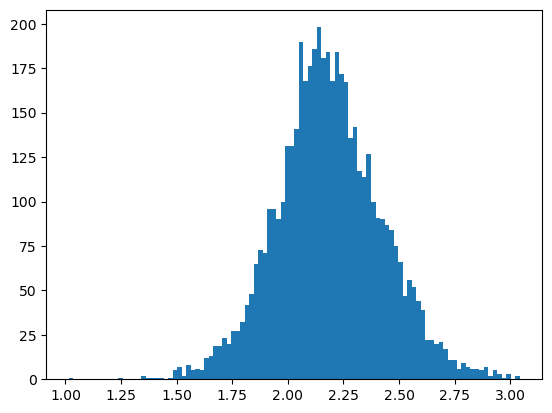

In [28]:
rmsd_matrix = np.array(AllChem.GetConformerRMSMatrix(mol))
import matplotlib.pyplot as plt
plt.hist(rmsd_matrix.flatten(),bins=100)

In [30]:
#make a new mol, with only the selected conformers
new_mol = Chem.Mol(mol)
#remove all conformers
new_mol.RemoveAllConformers()
#add the selected conformers
for i in selected_indices:
    new_mol.AddConformer(mol.GetConformer(i))
#check if it worked
from rdkit.Chem.rdMolAlign import GetBestRMS
for i in range(new_mol.GetNumConformers()):
    for j in range(new_mol.GetNumConformers()):
        #get the rmsd value
        if i != j:
            rms = GetBestRMS(mol,mol,i,j)
            print(f'rmsd between confs {i} and {j}: {rms}')

rmsd between confs 0 and 1: 1.6406240940379404
rmsd between confs 0 and 2: 1.8722653192694891
rmsd between confs 0 and 3: 1.7831569759391166
rmsd between confs 0 and 4: 1.9883034472164096
rmsd between confs 1 and 0: 1.6406240940411663
rmsd between confs 1 and 2: 1.8024643382140737
rmsd between confs 1 and 3: 1.8411598358885826
rmsd between confs 1 and 4: 1.9245790691444653
rmsd between confs 2 and 0: 1.8722653192015313
rmsd between confs 2 and 1: 1.802464338202796
rmsd between confs 2 and 3: 1.667899420257067
rmsd between confs 2 and 4: 1.9026607128892086
rmsd between confs 3 and 0: 1.7831569759359096
rmsd between confs 3 and 1: 1.841159835888581
rmsd between confs 3 and 2: 1.6678994202570743
rmsd between confs 3 and 4: 1.7375706535323934
rmsd between confs 4 and 0: 1.9883034472164045
rmsd between confs 4 and 1: 1.924579069144459
rmsd between confs 4 and 2: 1.9026607121414507
rmsd between confs 4 and 3: 1.737570653532389


In [41]:
from rdkit.Chem import rdMolAlign
rdMolAlign.AlignMolConformers(new_mol)
import py3Dmol
def drawit(m, cids=[-1], p=None, removeHs=True,
           colors=('cyanCarbon','redCarbon','blueCarbon','magentaCarbon','whiteCarbon','purpleCarbon')):
        if removeHs:
            m = Chem.RemoveHs(m)
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,cid in enumerate(cids):
            IPythonConsole.addMolToView(m,p,confId=cid)
        for i,cid in enumerate(cids):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()
#draw the conformers using drawit
drawit(new_mol,cids=[0,1,2])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.SimDivFilters import rdSimDivPickers

# Load your molecule and its conformers

conformers = [mol.GetConformer(i) for i in range(mol.GetNumConformers())]

# Initialize the MaxMinPicker
picker = rdSimDivPickers.MaxMinPicker()

# Set the number of conformers you want to sample (X)
cluster_picker = rdSimDivPickers.HierarchicalClusterPicker(rdSimDivPickers.ClusterMethod.CLINK)

# Set the number of conformers you want to sample (X)
num_to_pick = 5
import numpy as np
rmsd_matrix = np.array(AllChem.GetConformerRMSMatrix(mol))

# Perform hierarchical clustering
clusters = cluster_picker.Cluster(rmsd_matrix, len(conformers), num_to_pick)

# Retrieve the selected conformers from the clusters
selected_indices = [cluster[0] for cluster in clusters]
selected_conformers = [conformers[i] for i in selected_indices]

In [42]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.SimDivFilters import rdSimDivPickers



# Initialize the MaxMinPicker
picker = rdSimDivPickers.MaxMinPicker()

# Set the number of conformers you want to sample (X)
num_to_pick = 5

# Define a custom distance function that calculates RMSD between two conformers
def custom_rmsd_distance(i, j):
    return AllChem.GetBestRMS(mol,mol,i,j)

# Use the custom distance function within MaxMinPicker
selected_indices = picker.LazyPick(custom_rmsd_distance, 100, 5)



In [46]:
selected_indices
#get the indices from this <rdkit.rdBase._vecti at 0x7fba2b01d840>
selected_indices = list(selected_indices)
selected_indices
#now get the rmsds for these
for i in selected_indices:
    for j in selected_indices:
        #get the rmsd value
        if i != j:
            rms = GetBestRMS(mol,mol,i,j)
            print(f'rmsd between confs {i} and {j}: {rms}')
        

rmsd between confs 65 and 50: 2.1727923792917423
rmsd between confs 65 and 36: 1.9660023211754023
rmsd between confs 65 and 26: 1.9314481363509755
rmsd between confs 65 and 49: 1.8444621422134064
rmsd between confs 50 and 65: 2.1727923792917387
rmsd between confs 50 and 36: 2.0098557671498933
rmsd between confs 50 and 26: 1.889469835723645
rmsd between confs 50 and 49: 2.046823627843166
rmsd between confs 36 and 65: 1.9660023211776323
rmsd between confs 36 and 50: 2.0098557671726307
rmsd between confs 36 and 26: 1.9729818630205995
rmsd between confs 36 and 49: 1.8726990810394015
rmsd between confs 26 and 65: 1.9314481363509832
rmsd between confs 26 and 50: 1.8894698357236492
rmsd between confs 26 and 36: 1.9729818627747548
rmsd between confs 26 and 49: 2.0663426382807253
rmsd between confs 49 and 65: 1.8444621422134064
rmsd between confs 49 and 50: 2.0468236277526524
rmsd between confs 49 and 36: 1.872699079861619
rmsd between confs 49 and 26: 2.0663426382534613


In [52]:
#much better, now lets look at these too; make a new mol in which we only keep the selected conformers
new_mol = Chem.Mol(mol)
#remove all conformers
new_mol.RemoveAllConformers()
#add the selected conformers
for i in selected_indices:
    new_mol.AddConformer(mol.GetConformer(i))
print(new_mol.GetNumConformers())
#get confids
rdMolAlign.AlignMolConformers(new_mol)

confids = [conf.GetId() for conf in new_mol.GetConformers()]
print(confids)
#check if it worked
drawit(new_mol,cids=confids)

5
[65, 50, 36, 26, 49]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
#using script from Greg; we are going to generate 100 conformers from whole dataset, and just pick a few from each molecule.
#first load all molecules that are working right now (for which we have some)

cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = """
SELECT mdfp_experiment_data.confid, 
       mdfp_experiment_data.mdfp, 
       conformers.molregno, 
       experimental_data.*
FROM cs_mdfps_schema.mdfp_experiment_data
INNER JOIN public.conformers ON mdfp_experiment_data.confid = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.experimental_data ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
"""

# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(len(results))
print(results[0])
confids = [x[0] for x in results]
smiles = [x[7]['SMILES'] for x in results]
molregnos = [x[3] for x in results]
print(len(smiles))
print(confids[0])
print(smiles[0])
print(molregnos[0])
smiles[0]

3019
(1150, {'mdfp': '[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.361432252633201, 0.2837151924402524, 7.34042141946558, 14.033742219875462, 5.018821051018752, 13.296541873715412, 3.0175857863467783, 4.353506155897645, 3.780431651235485, -52.02286927297752, 7.64448526452626, -52.45103811827988, 21.39517447250866, 4.952106406604119, 20.619064966261192, -49.00528348663075, 8.735995589648539, -49.230908851076755, 0.2920177211844079, 0.017855504243481337, 0.2924185563222354, 3.8179197, 0.071479075, 3.8226213]'}, 7, 7, 0, {}, -0.3010669122639207, {'SMILES': '[CH3]-[CH]=[CH]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH3]', 'Source': 298.15, 'Temperature': 298.15})
3019
1150
[CH3]-[CH]=[CH]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH3]
7


'[CH3]-[CH]=[CH]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH3]'

In [10]:
#make list of tuples with each tupl containing (molregno, smiles)
molregno_smiles = list(zip(molregnos,smiles))
molregno_smiles[0]
import gzip
import pickle
outfn = 'VP_molregno_smiles.pkl.gz'
with gzip.open(outfn,'wb+') as outf:
    pickle.dump(molregno_smiles,outf)

In [13]:
#lets make two new tables; cs_mdfp_schema.confid_data and cs_mdfp_schema.confid_metadata.
#cs_mdfp_schema.confid_data has as primary key confid and has two columns: confid and confgen_uuid.
#cs_mdfp_schema.confid_metadata has as primary key confgen_uuid and has two columns: confgen_uuid and metadata as jsonb
cn = utils._connect(config)
cur = cn.cursor()
cur.execute('create table cs_mdfps_schema.confid_data(confid int primary key, confgen_uuid text)')
cur.execute('create table cs_mdfps_schema.confid_metadata(confgen_uuid text primary key, metadata jsonb)')
cn.commit()


In [15]:
#lets make an entry in confid_metadata; we need to generate a uuid for this
import uuid
confgen_uuid = uuid.uuid4()
print(confgen_uuid)
params = {"enforceChirality":True, 
          "randomSeed":0xf00d,
          "MMFF_minimization":False}
params_json = json.dumps(params)
cur.execute('insert into cs_mdfps_schema.confid_metadata values (%s,%s)',(str(confgen_uuid),str(params_json)))
cn.commit()


906589dd-76fa-4d7b-aa9f-1ee90abe3835


In [18]:
#now register all confids in confid_data with 906589dd-76fa-4d7b-aa9f-1ee90abe3835 as confgen_uuid
for confid in confids:
    cur.execute('insert into cs_mdfps_schema.confid_data values (%s,%s)',(str(confid),str(confgen_uuid)))
cn.commit()

In [25]:
#wait, does molregno care about stereo?
#or wait lets not be stupid! we can just use the smiles from the mols that we actualy registered!
#lets join cs_mdfp_schema.mdfp_experiment_data with conformers on confid
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute('select * from cs_mdfps_schema.mdfp_experiment_data inner join public.conformers on cs_mdfps_schema.mdfp_experiment_data.confid = public.conformers.conf_id')
results = cur.fetchall()
print(len(results))
print(results[0])
confids = [x[0] for x in results]
molblocks = [x[-1] for x in results]
print(confids[0])
print(molblocks[0])
molregnos = [x[6] for x in results]
print(len(molregnos))
print(molregnos[0])
#okay now mols from the molblocks and smiles from these mols


3019
(1150, 'fc57851e-b654-4338-bcdd-faa28ec66253', {'mdfp': '[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.361432252633201, 0.2837151924402524, 7.34042141946558, 14.033742219875462, 5.018821051018752, 13.296541873715412, 3.0175857863467783, 4.353506155897645, 3.780431651235485, -52.02286927297752, 7.64448526452626, -52.45103811827988, 21.39517447250866, 4.952106406604119, 20.619064966261192, -49.00528348663075, 8.735995589648539, -49.230908851076755, 0.2920177211844079, 0.017855504243481337, 0.2924185563222354, 3.8179197, 0.071479075, 3.8226213]'}, '9955d786-2e1a-49c6-9abd-0c8e8b6757da', 'fc57851e-b654-4338-bcdd-faa28ec66253', 1150, 7, '-0.922,-0.607,0.235;-2.194,-0.362,-0.51;-2.8,1.702,0.771;-3.241,0.356,0.298;0.031,-1.329,-0.69;1.354,-1.62,-0.015;2.026,-0.357,0.424;3.217,-0.065,-0.061;3.906,1.169,0.35', '[H]/C(=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 C

In [26]:
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
smiles = [Chem.MolToSmiles(mol) for mol in mols]
print(smiles[0])
print(len(smiles))
print(molregnos[0],confids[0])
#


[11:14:05] Warning: molecule is tagged as 3D, but all Z coords are zero


C/C=C/CCCCCC
3019
7 1150


In [27]:
#make list of tuples with each tupl containing (molregno, smiles)
molregno_smiles = list(zip(molregnos,smiles))
molregno_smiles[0]
import gzip
import pickle
outfn = 'VP_molregno_smiles.pkl.gz'
with gzip.open(outfn,'wb+') as outf:
    pickle.dump(molregno_smiles,outf)

In [28]:
infile = './VP_molregno_smiles.pkl.gz'
with gzip.open(infile,'rb') as inf:
    ind =pickle.load(inf)
print(len(ind))
print(ind[0])

3019
(7, 'C/C=C/CCCCCC')


In [29]:
import uuid
confgen_uuid = uuid.uuid4()
print(confgen_uuid)

11093a30-b6d0-4e3f-a22b-8dcad60d6a11


In [80]:
import glob
import pickle
import gzip

molregnos,mols,errors = [],[],[]
for file in glob.glob('./confgen/*.pkl.gz'):
    with gzip.open(file,'rb') as inf:
        ind =pickle.load(inf)
        for mol in ind:
            molregnos.append(mol[0])
            mols.append(mol[1])
            errors.append(mol[2])
print(len(molregnos),len(mols),len(errors))
print(molregnos[:5])
print(mols[:5])
print(errors[:5])

3019 3019 3019
[15, 129, 226, 331, 553]
[<rdkit.Chem.rdchem.Mol object at 0x7fba2b060860>, <rdkit.Chem.rdchem.Mol object at 0x7fba29d78fe0>, <rdkit.Chem.rdchem.Mol object at 0x7fba2ae07c40>, <rdkit.Chem.rdchem.Mol object at 0x7fba28c5b7e0>, <rdkit.Chem.rdchem.Mol object at 0x7fba28c5bf60>]
[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)]


(array([621., 247., 189., 103.,  50.,  65.,  31.,  40., 100.,  54.,  41.,
         34.,  27.,  20.,  25.,  14.,  19.,  25.,  15.,  11.,  12.,  18.,
         13.,  24.,  24.,  32.,  20.,  18.,  14.,  19.,   5.,  13.,   7.,
         10.,   7.,  13.,  12.,   8.,   6.,   6.,   7.,   8.,   5.,   8.,
          5.,   6.,   7.,   9.,   5.,  10.,  14.,   7.,  14.,   6.,  10.,
         12.,   8.,  11.,   6.,   7.,  13.,   5.,  11.,   6.,  10.,   9.,
         10.,  12.,   8.,   6.,   7.,   9.,  11.,  15.,   3.,  13.,  12.,
         11.,  13.,  11.,  11.,  10.,  14.,   9.,   6.,  10.,   7.,   8.,
          5.,   6.,  13.,  21.,  13.,  21.,  23.,  29.,  33.,  37.,  61.,
        310.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  22.78,  23.77,
         24.76,  25.75,  26.74,  27.73,  28.72,  29.71,  30.7 ,  31.69,
         32.68,  33.67,  34.66

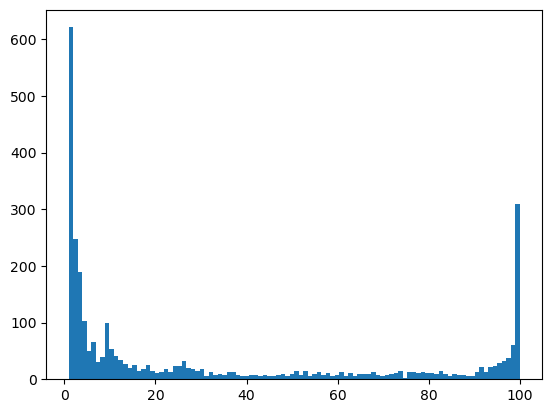

In [64]:
num_confs = [m.GetNumConformers() for m in mols]
#histogram
import matplotlib.pyplot as plt
plt.hist(num_confs,bins=100)

3


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

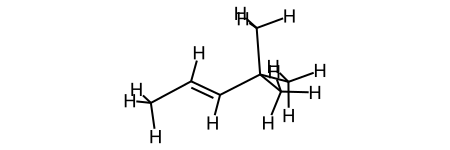

In [66]:
#wait lets see what happens if we store 1
test_mol = mols[0]
print(test_mol.GetNumConformers())
test_mol

In [67]:
#lets see what happens if we query for this mol
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'scotland'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True

In [68]:
lwreg.register(config=config, mol=test_mol,)
#okay, so I guess it just stores the first conformer

(15, 4257)

In [74]:
with Chem.SDWriter('test_mol.sdf') as w:
  for cid in cids:
    w.write(test_mol,confId=cid)

3


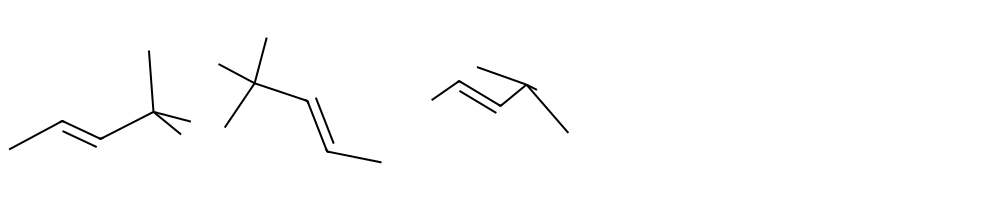

In [77]:
#now read
r = Chem.SDMolSupplier('test_mol.sdf')
#get mols
mols = [mol for mol in r]
print(len(mols))
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200))

In [89]:
from tqdm import tqdm
with Chem.SDWriter('11093a30-b6d0-4e3f-a22b-8dcad60d6a11.sdf') as w:
    for mol in tqdm(mols):
        cids = [conf.GetId() for conf in mol.GetConformers()]
        for cid in cids:
            w.write(mol,confId=cid)

100%|██████████| 3019/3019 [00:13<00:00, 217.21it/s]


In [91]:
mols_one_conf_sup = Chem.SDMolSupplier('11093a30-b6d0-4e3f-a22b-8dcad60d6a11.sdf',removeHs=False)
mols_one_conf = [mol for mol in mols_one_conf_sup]
print(len(mols_one_conf))

100833


In [ ]:
#now we can register them
tupp_list =[]
for mol in tqdm(mols_one_conf):
    tupp =lwreg.register(config=config, mol=mol,)
    tupp_list.append(tupp)